In [62]:
import sys, os, time

import open3d as o3d
import trimesh

import cv2

import scipy as sp
from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix, identity
from scipy.sparse.linalg import spsolve

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

In [63]:
def show_mesh(plys):
    o3d.visualization.draw_geometries(plys)
def save_mesh(path, mesh):
    o3d.io.write_triangle_mesh(path, mesh)

## 1 Uniform Laplace

In [64]:
# Load a mesh
mesh = trimesh.load('meshes/curvatures/lilium_s.obj')

### Mean curvature

Realize uniform Laplace-Beltrami operator:

$\Delta f(v_i)=\frac{1}{|\mathcal{N}_1(v_i)|}\sum\limits_{v_j\in\mathcal{N}_1(v_i)}(f_j-f_i)$

In [65]:
def uniform_laplacian(vertices, n1):
    """
    Uniform Laplace-Beltrami Operator

    Args:
        vertices:   (n, 3) float, the vertices of the mesh.
        n1:         (n,) int, The one-ring neighbors of each vertex of the mesh.
    
    Returns:
        lap:        (n, 3) float, the result after applying 
                    Uniform Laplace-Beltrami Operator to each vertex.
    """

    lap = np.zeros(vertices.shape)
    for i, n in enumerate(n1):
        vn = vertices[n]
        lap[i] = np.sum(vn - vertices[i], axis=0) / len(n)
        
    return lap

Compute mean curvature $H$ using uniform Laplace-Beltrami operator.

$H(v_i)=\frac{1}{2}||\Delta \mathbf{x}_i||$, where $\mathbf{x}(v_i)=(x_i, y_i, z_i)$ is the coordinate function.

In [66]:
def mean_curvature(mesh):
    """
    Calculate mean curvature H using uniform Laplace-Beltrami operator.

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        H:          (n,) float, mean curvature on each vertex.
    """

    ul = uniform_laplacian(mesh.vertices, mesh.vertex_neighbors)
    H = 0.5 * np.linalg.norm(ul, axis=1)
    
    return H

### Gaussian curvature

Compute Gaussian curvature $K(v_i)$

$K(v_i)=\frac{1}{A_i}(2\pi-\sum\limits_{v_j\in\mathcal{N}_1(v_i)}\theta_j)$

<img src="report/imgs/1.png" alt="1" style="zoom:66%;" />

Compute the sum of $\theta_j$ of each vertex:

Traverse each face of the mesh, accumulate the angles on each vertex to the sum of theta corresponding to each vertex.

In [67]:
def vertex_theta(mesh):
    """
    Compute the sum of theta_j of each vertex.

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        thetas:     (n,) float, sum of theta_j of each vertex.
    """

    # Use it the accumulate thetas of each vertex.
    thetas = np.zeros((mesh.vertices.shape[0],))

    # Traverse each face of the mesh
    for face, angles in zip(mesh.faces, mesh.face_angles):
        # Accumulate the angles
        thetas[face] += angles

    return thetas

In [68]:
# Helper functions

def mid_point(point1, point2):
    # Compute the midpoint of two points.
    return 0.5 * (point1 + point2)

def tri_area(a, b, c):
    # Use cross product to calculate the area of a triangle 
    # determined by three vertices.
    return 0.5 * np.linalg.norm(np.cross(b - a, c - a))

def tri_center(a, b, c):
    # Compute triangle barycenter.
    return (a + b + c) / 3.

<img src="report/imgs/2.png" alt="2" style="zoom:66%;" />

My code use barycentric cell as $A_i$ (although the picture above represents Mixed Voronoi Cell).

For each vertex on each face of the mesh, compute the area of the area connected by the vertex, the midpoints and the barycenter, as the red region in the image above. Then accumulate it into the $A_i$ correspoding to the vertex.

In [69]:
def cal_part_Ai(xi, xj, xk):
    """
    Compute the area of part of the averaging region A_i of each vertex.

    Args:
        xi:         (3,) float, the coordinate of one vertex.
        xj, xk:     (3,) float, the coordinates of two vertices
                    which can form a face on the mesh.
    
    Returns:
        part_Ai:    float, the area of the part of A_i corresponding to xi.
    """

    mid = tri_center(xi, xj, xk)
    mij = mid_point(xi, xj)
    mik = mid_point(xi, xk)
    part_Ai = tri_area(xi, mid, mij) + tri_area(xi, mid, mik)
    
    return part_Ai

<img src="report/imgs/4.png" alt="4" style="zoom:66%;" />

Accumulate part of $A_i$ of vertices into the $A_i$ correspoding to the vertices to compute the area of Barycentric cell.

In [70]:
# Convenient for indexing
ia = [0, 1, 2]
ib = [1, 0, 2]
ic = [2, 0, 1]

def vertex_area(mesh):
    """
    Compute the area of the averaging region A_i of each vertex.

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        A:          (n,) float, the area of A_i corresponding to each vertices.
    """

    A = np.zeros((mesh.vertices.shape[0],))
    vertices = mesh.vertices
    for face in mesh.faces:
        A[face] += np.array([
            cal_part_Ai(*vertices[face[ia]]),
            cal_part_Ai(*vertices[face[ib]]),
            cal_part_Ai(*vertices[face[ic]]),
        ])
    
    return A

Compute Gaussian curvature $K(v_i)$

$K(v_i)=\frac{1}{A_i}(2\pi-\sum\limits_{v_j\in\mathcal{N}_1(v_i)}\theta_j)$

In [71]:
def gaussian_curvature(mesh):
    """
    Compute Gaussian curvature K of each vertices

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        K:          (n,) float, gaussian curvature on each vertex.
    """
    thetas = vertex_theta(mesh)
    A = vertex_area(mesh)
    K = (2 * np.pi - thetas) / A
    return K

Color of each vertex according to the curvature.

![1](report/plots/1.png)

In [72]:
def color_vertices_by_curvature(C, bins):
    """
    Compute the color of each vertex according to the curvature.

    Args:
        C:          (n,) float, the curvatures of vertices.
        bins:       int, the function use Histogram Equalization to enhance
                    the contrast of the vertices color. Lager bins means 
                    more homogeneous normalisation.
    
    Returns:
        c:          (n, 3) float, the rgb colors of vertices
    """

    # Copy the curvature to prevent altering the origin curvature.
    a = C.copy()

    # Normalize curvature to [0, 1]
    a -= np.min(a)
    a /= np.max(a)

    # Histogram Equalization
    hist, bins = np.histogram(a, bins, [0, 1])
    cdf = hist.cumsum()
    cdf = cdf / cdf[-1]
    a = np.interp(a, bins[:-1], cdf)

    # Fisrt compute the HSV colors by normalized curvatures.
    a = 1 - a
    # Saturation and Value are set to 255, Hue is determined by the curvature.
    b = np.vstack((a * 120, np.ones(a.shape) * 255, np.ones(a.shape) * 255)).T
    b = b.reshape((b.shape[0], 1, 3)).astype(np.uint8)

    # Convert HSV colors to RGB colors.
    c = cv2.cvtColor(b, cv2.COLOR_HSV2RGB)
    c = c.reshape((c.shape[0], 3)).astype(np.float32)
    c /= 255.
    
    return c

In [73]:
# Helper function
def save_mesh_with_curvature(mesh, C, file_name, bins):
    o3d_mesh = mesh.as_open3d
    o3d_mesh.vertex_colors = o3d.utility.Vector3dVector(color_vertices_by_curvature(C, bins))
    save_mesh(file_name, o3d_mesh)

Resulting meshes saved in `res/curvature`

In [74]:
H = mean_curvature(mesh)
K = gaussian_curvature(mesh)
save_mesh_with_curvature(mesh, H, 'res/curvature/H_lilium_s.obj', 15)
save_mesh_with_curvature(mesh, K, 'res/curvature/K_lilium_s.obj', 2000) 

## 2 First and Second Fundamental forms

In [75]:
# Pre-defined ellipsoid parameters
a = 2
b = 3
c = 4

def p_ellipsoid(u, v):
    # Coordinate function of the ellipsoid
    x = a * np.cos(u) * np.sin(v)
    y = b * np.sin(u) * np.sin(v)
    z = c * np.cos(v)
    return x, y, z

def J_ellipsoid(u, v):
    # First order differentiation of the coordinate function
    x_u = np.array([
        -a * np.sin(u) * np.sin(v),
        b * np.cos(u) * np.sin(v),
        0
    ])
    x_v = np.array([
        a * np.cos(u) * np.cos(v),
        b * np.sin(u) * np.cos(v),
        -c * np.sin(v)
    ])
    return x_u, x_v

def H_ellipsoid(u, v):
    # Second order differentiation of the coordinate function
    x_uu = np.array([
        -a * np.cos(u) * np.sin(v),
        -b * np.sin(u) * np.sin(v),
        0
    ])
    x_uv = np.array([
        -a * np.sin(u) * np.cos(v),
        b * np.cos(u) * np.cos(v),
        0
    ])
    x_vv = np.array([
        -a * np.cos(u) * np.sin(v),
        -b * np.sin(u) * np.sin(v),
        -c * np.cos(v)
    ])
    return x_uu, x_uv, x_vv

def n_ellipsoid(u, v):
    # Normal vector of a specific point on the ellipsoid
    x_u, x_v = J_ellipsoid(u, v)
    n = np.cross(x_u, x_v)
    return n / np.linalg.norm(n)

def I_ellipsoid(u, v):
    # The first fundamental form of a specific point on the ellipsoid
    x_u, x_v = J_ellipsoid(u, v)
    E = x_u @ x_u
    F = x_u @ x_v
    G = x_v @ x_v
    return E, F, G

def II_ellipsoid(u, v):
    # The Second fundamental form of a specific point on the ellipsoid
    x_uu, x_uv, x_vv = H_ellipsoid(u, v)
    n = n_ellipsoid(u, v)
    e = x_uu @ n
    f = x_uv @ n
    g = x_vv @ n
    return e, f, g

Compute the normal curvature $\kappa_n$ at the point $(a,0,0)$.

In [76]:
def curvature_ellipsoid_at_uv(u_t, v_t):
    
    # The value of u, v on the point (a, 0, 0)
    u = 0
    v = np.pi / 2.

    E, F, G = I_ellipsoid(u, v)
    e, f, g = II_ellipsoid(u, v)

    k_n = (e*u_t*u_t + 2*f*u_t*v_t + g*v_t*v_t) / (E*u_t*u_t + 2*F*u_t*v_t + G*v_t*v_t)

    return k_n

Take unit vectors $\overline{\mathbf{t}}$ on the tangent plane at $(a, 0, 0)$, where $\overline{\mathbf{t}}=(u_t, v_t), u_t=\cos(\theta), v_t=\sin(\theta), \theta\in[0,2\pi]$. Compute the curvatures and show the plot.

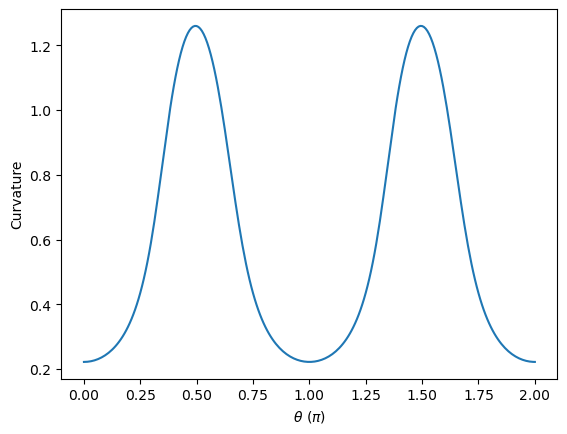

In [77]:
thetas = np.linspace(0, 2 * np.pi, 2**8+1)
curvatures = []
for theta in thetas:
    u_t = np.cos(theta)
    v_t = np.sin(theta)
    c = curvature_ellipsoid_at_uv(u_t, v_t)
    curvatures.append(c)
plt.ylabel('Curvature')
plt.xlabel('$\\theta \\ (\pi)$')
plt.plot(thetas / np.pi, curvatures)

## 3 Non-uniform (Discrete Laplace-Beltrami)

Cotangent weighed Laplace-Beltami operator:

$\Delta f(v_i)=\frac{1}{2A_i}\sum\limits_{v_j\in\mathcal{N}_1(v_i)}(\cot\alpha_{i, j}+\cot\beta_{i, j})(f_j-f_i)$

<img src="report/imgs/1.png" alt="1" style="zoom:66%;" />



Compute the sum of $(\cot\alpha_{i, j}+\cot\beta_{i, j})(f_j-f_i)$ of each vertex:

Traverse each face of the mesh, each angle of each vertex will contribute to the cotangent weight of the other two vertex.

In [78]:
# Convenient for indexing
ij = [[1, 2], [0, 2], [0, 1]]

def vertex_cot(mesh):
    """
    Compute the cotangent weight of each vertex.

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        cots:       (n,) float, the cotangent weight of each vertex.
    """

    cots = np.zeros((mesh.vertices.shape))
    vertices = mesh.vertices

    # Traverse each face of the mesh.
    for face, angles in zip(mesh.faces, mesh.face_angles):
        # Traverse each vertex of the face.
        for i in range(3):
            # Compute the cotangent of the angle of the vertex.
            cotij = 1. / np.tan(angles[i])
            # The difference between the coordinates of the other two vertices.
            delta = vertices[face[ij[i][1]]] - vertices[face[ij[i][0]]]
            # Make contribution.
            cots[face[ij[i]]] += np.array([cotij * delta, -cotij * delta])

    return cots

In [79]:
def cot_Laplace_Beltrami(mesh):
    """
    Cotangent Laplace-Beltrami Operator

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        clb:        (n, 3) float, the result after applying 
                    Cotangent Laplace-Beltrami Operator to each vertex.
    """

    cots = vertex_cot(mesh)
    A = vertex_area(mesh)
    clb = cots / (2. * np.vstack((A, A, A)).T)
    
    return clb

In [80]:
def cot_mean_curvature(mesh):
    """
    Calculate mean curvature H_cot using cotangent discretization.

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        H_cot:          (n,) float, mean curvature on each vertex using cotangent discretization.
    """

    clb = cot_Laplace_Beltrami(mesh)
    H_cot = 0.5 * np.linalg.norm(clb, axis=1)
    
    return H_cot

Resulting meshes saved in `res/curvature`

In [101]:
H_cot = cot_mean_curvature(mesh)
save_mesh_with_curvature(mesh, H_cot, 'res/curvature/H_cot_lilium_s.obj', 40)

In [102]:
mesh = trimesh.load('meshes/curvatures/plane.obj')

H = mean_curvature(mesh)
K = gaussian_curvature(mesh)
H_cot = cot_mean_curvature(mesh)
save_mesh_with_curvature(mesh, H, 'res/curvature/H_plane.obj', 15)
save_mesh_with_curvature(mesh, K, 'res/curvature/K_plane.obj', 2000) 
save_mesh_with_curvature(mesh, H_cot, 'res/curvature/H_cot_plane.obj', 40)

## 4 Modal analysis

Compute the matrix of un-uniform Laplace-Beltrami operator:

$\Delta f(v_i)=\sum\limits_{v_j\in\mathcal{N}_1(v_i)}(f_j-f_i)$

In [84]:
def construct_Laplace_Beltrami_matrix(mesh):
    """
    Compute the matrix of un-uniform Laplace-Beltrami operator for a mesh.

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        csr_L:      scipy.sparse.csr_matrix, 
                    the sparse representation of the un-uniform Laplace-Beltrami matrix 
    """

    # To contruct csr_matrix
    data = []
    indices = []
    indptr = [0]

    vertices = mesh.vertices
    neighbours = mesh.vertex_neighbors
    for i, n in enumerate(neighbours):
        n_cnt = len(n)
        rdata = np.ones((n_cnt + 1,))
        rdata[n_cnt] = -n_cnt
        rindices = np.zeros((n_cnt + 1,))
        rindices[:n_cnt] = np.array(n)
        rindices[n_cnt] = i
        ri = np.argsort(rindices)
        data.extend(rdata[ri].tolist())
        indices.extend(rindices[ri].tolist())
        indptr.append(indptr[-1] + n_cnt + 1)
        
    csr_L = csr_matrix((data, indices, indptr), shape=(vertices.shape[0], vertices.shape[0]), dtype=np.float32)

    return csr_L

Compute mesh reconstruction

$\widetilde{\mathbf{x}}=\sum\limits_{i=1}^{k}\langle \mathbf{e}_i, \mathbf{x}\rangle \mathbf{e}_i$, where $\mathbf{x}$ represents the cooredinate function, and $\mathbf{e}$ is the eigenvectors of the Laplace-Beltrami matrix.

In [85]:
def mesh_reconstruction(mesh, k):

    # Compute sparse Laplace-Beltrami matrix
    csr_L = construct_Laplace_Beltrami_matrix(mesh)

    # Compute the k-smallest eigenvalues and their eigenvectors
    w, v = eigs(csr_L, k=k, which='SM')
    w = w.real
    v = v.real

    # Copy the origin mesh
    smooth_mesh = mesh.copy()

    # Get the vertices corrdinates
    vertices = np.asarray(smooth_mesh.vertices)

    # To store the corrdinates after reconstruction
    smooth_vertices = np.zeros(vertices.shape)

    # Reconstrction
    ef = vertices.T @ v
    for ch in range(3):
        smooth_vertices[:, ch] = np.sum(np.tile(ef[ch], (vertices.shape[0], 1)) * v, axis=1)
    smooth_mesh.vertices = smooth_vertices
    
    return smooth_mesh

In [107]:
# Load a mesh
mesh = trimesh.load('meshes/decomposition/armadillo.obj')

# Reconstruct mesh
k = 1000
smooth_mesh = mesh_reconstruction(mesh, k)

# Save reconstructed mesh
save_mesh('res/reconstruction/armadillo_1000.obj', smooth_mesh.as_open3d)

In [105]:
k = 5
smooth_mesh = mesh_reconstruction(mesh, k)
save_mesh('res/reconstruction/armadillo_5.obj', smooth_mesh.as_open3d)

k = 15
smooth_mesh = mesh_reconstruction(mesh, k)
save_mesh('res/reconstruction/armadillo_15.obj', smooth_mesh.as_open3d)

## 5 Explicit Laplacian mesh smoothing

Compute the matrix of uniform Laplace-Beltrami operator:

$\Delta f(v_i)=\frac{1}{|\mathcal{N}_1(v_i)|}\sum\limits_{v_j\in\mathcal{N}_1(v_i)}(f_j-f_i)$

In [90]:
def construct_uniform_Laplace_matrix(mesh):
    """
    Compute the matrix of uniform Laplace-Beltrami operator for a mesh.

    Args:
        mesh:       Trimesh, the data of mesh loaded by Trimesh.
    
    Returns:
        csr_L:      scipy.sparse.csr_matrix, 
                    the sparse representation of the uniform Laplace-Beltrami matrix 
    """

    # To contruct csr_matrix
    data = []
    indices = []
    indptr = [0]

    vertices = mesh.vertices
    neighbours = mesh.vertex_neighbors
    for i, n in enumerate(neighbours):
        n_cnt = len(n)
        rdata = np.ones((n_cnt + 1,)) / n_cnt
        rdata[n_cnt] = -1.
        rindices = np.zeros((n_cnt + 1,))
        rindices[:n_cnt] = np.array(n)
        rindices[n_cnt] = i
        ri = np.argsort(rindices)
        data.extend(rdata[ri].tolist())
        indices.extend(rindices[ri].tolist())
        indptr.append(indptr[-1] + n_cnt + 1)

    csr_L = csr_matrix((data, indices, indptr), shape=(vertices.shape[0], vertices.shape[0]), dtype=np.float32)
    
    return csr_L

Compute Laplacian mesh smoothing:

$\mathbf{x}_{i+1}\leftarrow\mathbf{x}_{i}+\lambda \mathbf{L}\mathbf{x}_{i}$, where $\mathbf{x}$ represents the cooredinate function, $\mathbf{L}$ is the uniform Laplace-Beltrami matrix and $\lambda$ is the smoothing speed.

In [96]:
def explicit_Laplacian_mesh_smoothing(mesh, lam=0.01, t=100):
    """
    Explicit Laplacian mesh smoothing.

    Args:
        mesh:           Trimesh, the data of mesh loaded by Trimesh.
        lam:            float, represents lambda
        t:              int, iteration round
    
    Returns:
        smooth_mesh:    Trimesh, smoothed mesh.
    """

    # Copy the original mesh
    smooth_mesh = mesh.copy()

    # Get the vertices corrdinates
    smooth_vertices = np.asarray(mesh.vertices)

    # Compute sparse uniform Laplace-Beltrami matrix
    csr_uL = construct_uniform_Laplace_matrix(mesh)

    # Iterate to smooth the mesh.
    for _ in tqdm(range(t)):
        smooth_vertices = smooth_vertices + lam * csr_uL @ smooth_vertices
    
    smooth_mesh.vertices = smooth_vertices
    
    return smooth_mesh

In [126]:
mesh = trimesh.load('meshes/smoothing/fandisk_ns.obj')
smooth_mesh = explicit_Laplacian_mesh_smoothing(mesh, lam=0.05, t=100)
save_mesh('res/smoothing/explict/fandisk_ns_explict_laplacian_005.obj', smooth_mesh.as_open3d)

100%|██████████| 100/100 [00:00<00:00, 3493.22it/s]


In [127]:
smooth_mesh = explicit_Laplacian_mesh_smoothing(mesh, lam=0.01, t=100)
save_mesh('res/smoothing/explict/fandisk_ns_explict_laplacian_001.obj', smooth_mesh.as_open3d)

smooth_mesh = explicit_Laplacian_mesh_smoothing(mesh, lam=0.1, t=100)
save_mesh('res/smoothing/explict/fandisk_ns_explict_laplacian_01.obj', smooth_mesh.as_open3d)

smooth_mesh = explicit_Laplacian_mesh_smoothing(mesh, lam=1, t=100)
save_mesh('res/smoothing/explict/fandisk_ns_explict_laplacian_1.obj', smooth_mesh.as_open3d)

smooth_mesh = explicit_Laplacian_mesh_smoothing(mesh, lam=1.5, t=100)
save_mesh('res/smoothing/explict/fandisk_ns_explict_laplacian_1_5.obj', smooth_mesh.as_open3d)

100%|██████████| 100/100 [00:00<00:00, 3499.57it/s]


In [98]:
H_sm = mean_curvature(smooth_mesh)
save_mesh_with_curvature(smooth_mesh, H_sm, 'res/smoothing/H_lilium_s_explict_laplacian.obj', 15)

## 6 Implicit Laplacian mesh smoothing

Compute implict Laplacian mesh smoothing:

Iterate by solving the linear system: $(\mathbf{I}-\lambda\mathbf{L})\mathbf{x}_{i+1}=\mathbf{x}_{i}$ represents the cooredinate function, $\mathbf{L}$ is the uniform Laplace-Beltrami matrix and $\lambda$ is the smoothing speed.

In [99]:
def implicit_Laplacian_mesh_smoothing(mesh, lam=0.01, t=20):
    """
    Implicit Laplacian mesh smoothing.

    Args:
        mesh:           Trimesh, the data of mesh loaded by Trimesh.
        lam:            float, represents lambda
        t:              int, iteration round
    
    Returns:
        smooth_mesh:    Trimesh, smoothed mesh.
    """
    
    # Copy the original mesh
    smooth_mesh = mesh.copy()
    
    # Get the vertices corrdinates
    smooth_vertices = np.asarray(mesh.vertices)
    vn = smooth_vertices.shape[0]

    # Compute sparse uniform Laplace-Beltrami matrix
    csr_uL = construct_uniform_Laplace_matrix(mesh)

    # Iterate to smooth the mesh.
    for _ in tqdm(range(t)):
        # Solve the linear system
        smooth_vertices = spsolve(identity(vn) - lam * csr_uL, smooth_vertices)
        smooth_mesh.vertices = smooth_vertices

    return smooth_mesh

In [128]:
mesh = trimesh.load('meshes/smoothing/fandisk_ns.obj')

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh, lam=0.5, t=100)
save_mesh('res/smoothing/implict/fandisk_ns_implict_laplacian_05_100.obj', smooth_mesh.as_open3d)

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh, lam=1.5, t=100)
save_mesh('res/smoothing/implict/fandisk_ns_implict_laplacian_15_100.obj', smooth_mesh.as_open3d)

100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


In [129]:
mesh = trimesh.load('meshes/smoothing/plane_ns.obj')

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh, lam=0.5, t=100)
save_mesh('res/smoothing/implict/plane_ns_implict_laplacian_05_100.obj', smooth_mesh.as_open3d)

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh, lam=1.5, t=100)
save_mesh('res/smoothing/implict/plane_ns_implict_laplacian_15_100.obj', smooth_mesh.as_open3d)

100%|██████████| 100/100 [00:00<00:00, 183.84it/s]


In [130]:
mesh = trimesh.load('meshes/smoothing/fandisk_ns.obj')

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh, lam=0.5, t=10)
save_mesh('res/smoothing/implict/fandisk_ns_implict_laplacian_05_10.obj', smooth_mesh.as_open3d)

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh, lam=1.5, t=10)
save_mesh('res/smoothing/implict/fandisk_ns_implict_laplacian_15_10.obj', smooth_mesh.as_open3d)

mesh = trimesh.load('meshes/smoothing/plane_ns.obj')

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh, lam=0.5, t=10)
save_mesh('res/smoothing/implict/plane_ns_implict_laplacian_05_10.obj', smooth_mesh.as_open3d)

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh, lam=1.5, t=10)
save_mesh('res/smoothing/implict/plane_ns_implict_laplacian_15_10.obj', smooth_mesh.as_open3d)

100%|██████████| 10/10 [00:00<00:00, 141.25it/s]


## 7 Evaluate

In [134]:
mesh = trimesh.load('meshes/smoothing/fandisk_ns.obj')
mesh_ns = mesh.copy()

sig = 1

vertices = mesh.vertices
noises = np.random.normal(0, sig, vertices.shape)
mesh_ns.vertices = vertices + noises

save_mesh('res/evaluate/fandisk_ns_noise_1.obj', mesh_ns.as_open3d)

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh_ns, lam=1.5, t=10)
save_mesh('res/evaluate/fandisk_noise_smooth_1.obj', smooth_mesh.as_open3d)

100%|██████████| 10/10 [00:00<00:00, 14.35it/s]


In [135]:
mesh = trimesh.load('meshes/smoothing/fandisk_ns.obj')
mesh_ns = mesh.copy()

sig = 0.1

vertices = mesh.vertices
noises = np.random.normal(0, sig, vertices.shape)
mesh_ns.vertices = vertices + noises

save_mesh('res/evaluate/fandisk_ns_noise_01.obj', mesh_ns.as_open3d)

smooth_mesh = implicit_Laplacian_mesh_smoothing(mesh_ns, lam=1.5, t=10)
save_mesh('res/evaluate/fandisk_noise_smooth_01.obj', smooth_mesh.as_open3d)

100%|██████████| 10/10 [00:00<00:00, 14.15it/s]
